In [1]:
"""
This file cleans trialData.csv, outputs two files: the cleaned version, and the feedback
"""
import json
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from os.path import basename

## PHASE 1: jsonStr Extraction

In [2]:
# Creates the dataframe
columnNames = ["SubjectID", "#", "trialId", "jsonStr"]
# File Selector
trial = pd.read_csv("trialdata.csv", names=columnNames, header=None)

In [3]:
# Set up the values we want to extract from the jsonStr column. The jsonStr column contains
# the data 
keys = ['rt', 'trial_type', 'view_history', 'internal_node_id', 'time_elapsed',
        'trial_index', 'responses', 'questions', 'imgName', 'isRepeat',
        'isRandom', 'stimulus', 'key_press', 'payment', 'total_unique_trials', 'random_num']
data = {key: [] for key in keys}

In [4]:
# Extractor
for jsonStr in trial.jsonStr:
    jsonDict = json.loads(jsonStr)
    for key in keys:
        try:
            data[key].append(jsonDict[key])
        except KeyError:
            data[key].append(None)

In [5]:
# Inserts the data into the trial dataframe
for key in keys:
    trial[key] = data[key]

In [6]:
# These are the keys for the question prompt.
# set up the values we want to extract for the question
qKeys = ['prompt', 'options', 'required', 'horizontal', 'labels']
qData = {key: [] for key in qKeys}

In [7]:
# Extractor for question - potential for multiple questions in a single trial hence the 
# lists
for questions in trial.questions:
    if questions is not None:
        prompt = []
        options = []
        required = []
        horizontal = []
        labels = []
        # row in the Column
        for question in json.loads(questions):
            try:
                prompt.append(question[key])
            except KeyError:
                prompt.append(None)

            try:
                options.append(question[key])
            except KeyError:
                options.append(None)

            try:
                required.append(question[key])
            except KeyError:
                required.append(None)

            try:
                horizontal.append(question[key])
            except KeyError:
                horizontal.append(None)

            try:
                labels.append(question[key])
            except KeyError:
                labels.append(None)

        qData['prompt'].append(prompt)
        qData['options'].append(options)
        qData['required'].append(required)
        qData['horizontal'].append(horizontal)
        qData['labels'].append(labels)
    else:
        for key in qKeys:
            qData[key].append([None])

In [8]:
# Inserts question dictionary values into trial dataframe
for key in qKeys:
    trial[key] = qData[key]

## PHASE 2: Subject Identification, Making the DF easier to read, output

In [9]:
# Debug ID: A6XBXQC3G59N8:3VP0C6EFSI3WXKQRF9ERIP60I906M0
trial = trial[trial.SubjectID != 'A6XBXQC3G59N8:3VP0C6EFSI3WXKQRF9ERIP60I906M0']

In [10]:
# We want a readable ID that we can quickly scan
subID_easy = {subId: None for subId in trial.SubjectID}
for i, key in enumerate(subID_easy):
    subID_easy[key] = int(i + 1)
trial.loc[:, 'SubjectID'] = trial.SubjectID.map(subID_easy)

In [11]:
# t contains subject attributes, payment, and total_unique_trials
t = trial[trial.trial_type == 'survey-multi-choice']
# how to select the last survey-multi-choice -> dictionary
#t.groupby('SubjectID')#.count()

#for att in t.iterrows():
#    print(att)

In [12]:
subAttribute = {iden: json.loads(resp) for iden, resp in zip(t.SubjectID, t.responses)}
payment = {i + 1: pay for i, pay in enumerate(t.payment)}
tut = {i + 1: to for i, to in enumerate(t.total_unique_trials)}

In [13]:
# This is used to identify the subject's location
numSubjects = max(trial.SubjectID)
subLoc = {i: None for i in range(1, numSubjects + 1)}
txts = trial[trial.trial_type == 'survey-text-req']
for i, txt in zip(txts.SubjectID, txts.responses):
    if i <= 20 and subLoc[i] is None:
        subLoc[i] = json.loads(txt)

In [14]:
# Reseting allows the index to be proper since we removed the debugger
trial = trial.reset_index(drop=True)

In [15]:
# Create the new columns/change the values in the columns
for i, subject in enumerate(trial.SubjectID):
    trial.loc[i, 'Age'] = subAttribute[subject]['Q0']
    trial.loc[i, 'Gender'] = subAttribute[subject]['Q1']
    trial.loc[i, 'Hispanic/Latino'] = subAttribute[subject]['Q2']
    trial.loc[i, 'Race'] = subAttribute[subject]['Q4']
    trial.loc[i, 'Education'] = subAttribute[subject]['Q5']
    
    trial.loc[i, 'State'] = subLoc[subject]['Q0']
    trial.loc[i, 'City'] = subLoc[subject]['Q1']
    trial.loc[i, 'Zipcode'] = subLoc[subject]['Q2']
    
    trial.loc[i, 'payment'] = payment[subject]
    
    trial.loc[i, 'total_unique_trials'] = tut[subject]

In [16]:
# Extraction of feedback and output of file
feedbacks = trial[trial.trial_type == 'survey-text'].responses
#>>>with open('feedback.txt', 'w') as f:
#>>>    for fb in feedbacks:
#>>>        statement = json.loads(fb)['Q0']
#>>>        if statement:
#>>>            f.write(statement + '\n')

In [17]:
# We now only want the trials
trial = trial[trial.trial_type == 'face-likert-amanda'].reset_index(drop=True)

In [18]:
# Makes the image names easier to read
names = sorted(set(trial.imgName), key=list(trial.imgName).index)
easy_name = {name: None for name in names}
for i, key in enumerate(easy_name):
    easy_name[key] = int(i + 1)
trial['ImgID'] = trial.imgName.map(easy_name)

In [19]:
# Score - we want to extract it from the json type and change it
for i,score in enumerate(trial.responses):
    trial.loc[i, 'Score'] = json.loads(score)['Q0']

In [20]:
# imgName -> we want it to be converted so that we have only the file name
for i, img in enumerate(trial.imgName):
    trial.loc[i, 'imgName'] = basename(img)

In [21]:
trial.columns

Index(['SubjectID', '#', 'trialId', 'jsonStr', 'rt', 'trial_type',
       'view_history', 'internal_node_id', 'time_elapsed', 'trial_index',
       'responses', 'questions', 'imgName', 'isRepeat', 'isRandom', 'stimulus',
       'key_press', 'payment', 'total_unique_trials', 'random_num', 'prompt',
       'options', 'required', 'horizontal', 'labels', 'Age', 'Gender',
       'Hispanic/Latino', 'Race', 'Education', 'State', 'City', 'Zipcode',
       'ImgID', 'Score'],
      dtype='object')

In [22]:
# Fixes order and selects the columns we want
trial = trial[['SubjectID', 'Score', 'rt', 'ImgID', 'imgName', 'trial_index', 'Age', 'Gender', 'Hispanic/Latino', 'Race', 'Education', 'State', 'Zipcode', 'payment', 'total_unique_trials']]

In [23]:
trial

,SubjectID,Score,rt,ImgID,imgName,trial_index,Age,Gender,Hispanic/Latino,Race,Education,State,Zipcode,payment,total_unique_trials
0,1,4.0,6706.0,1,empty-image-1.jpg,6,26-35,Male,No,White,High school degree or equivalent (e.g. GED),CO,80014,1.0,80.0
1,1,7.0,6257.0,2,Google_1_Kenneth Cabral_19_oval.jpg,8,26-35,Male,No,White,High school degree or equivalent (e.g. GED),CO,80014,1.0,80.0
2,1,3.0,3712.0,3,Google_1_Gary Nance_3_oval.jpg,9,26-35,Male,No,White,High school degree or equivalent (e.g. GED),CO,80014,1.0,80.0
3,1,4.0,3759.0,4,Google_1_Victoria Ambrose_17_oval.jpg,10,26-35,Male,No,White,High school degree or equivalent (e.g. GED),CO,80014,1.0,80.0
4,1,2.0,4251.0,5,Google_1_Claudia Rohrer_13_oval.jpg,11,26-35,Male,No,White,High school degree or equivalent (e.g. GED),CO,80014,1.0,80.0
5,1,3.0,2531.0,6,Google_1_Frank Luke_9_oval.jpg,12,26-35,Male,No,White,High school degree or equivalent (e.g. GED),CO,80014,1.0,80.0
6,1,3.0,2114.0,7,Google_1_Gregory Arriola_3_oval.jpg,13,26-35,Male,No,White,High school degree or equivalent (e.g. GED),CO,80014,1.0,80.0
7,1,6.0,2522.0,8,Google_1_Louis Mceachern_7_oval.jpg,14,26-35,Male,No,White,High school degree or equivalent (e.g. GED),CO,80014,1.0,80.0
8,1,4.0,3836.0,9,Google_1_Sean Raleigh_7_oval.jpg,15,26-35,Male,No,White,High school degree or equivalent (e.g. GED),CO,80014,1.0,80.0
9,1,3.0,2553.0,10,Google_1_Norman Westfall_5_oval.jpg,16,26-35,Male,No,White,High school degree or equivalent (e.g. GED),CO,80014,1.0,80.0


#### Unusable Data Subjects and reason
Subject 3: repeating pattern of 7, 8  
Subject 7: large number of repeating numbers  
Subject 9: repeating numbers  
Subject 14: 0,8 repeat numbers  

Subjects 7, 9, 14 are the same individual as according to location, pattern, and demograhic questions  
      can we ban this individual?  

In [24]:
unusable = [3, 7, 9, 14]
filteredTrial = trial
for iden in unusable:
    filteredTrial = filteredTrial[filteredTrial.SubjectID != iden]

In [25]:
# Output the new file into current directory
#>>>trial.to_csv('trialDataClean.csv')

## PHASE 4: General Analysis

#### response time

In [26]:
filteredTrial.rt.describe()

count     1856.000000
mean      3196.855065
std       1996.616581
min       1001.000000
25%       2323.000000
50%       2815.500000
75%       3491.250000
max      42973.000000
Name: rt, dtype: float64

(array([  0.,   0.,  70., 125., 438., 462., 302., 166., 104.,  58.,  41.,
         13.,  12.,  18.,   8.,   3.,   6.,   5.,   0.]),
 array([   0,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000,
        5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500]),
 <a list of 19 Patch objects>)

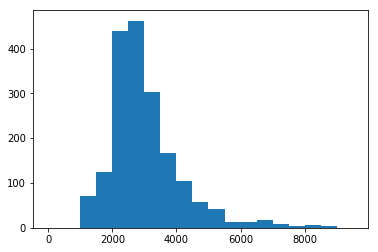

In [27]:
plt.hist(filteredTrial.rt, bins=list(range(0, 10000, 500)))

#### Score

In [28]:
filteredTrial.Score.describe()

count    1856.000000
mean        3.679418
std         1.976991
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         8.000000
Name: Score, dtype: float64

(array([155., 129., 238., 301., 334., 362., 220.,  81.,  36.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

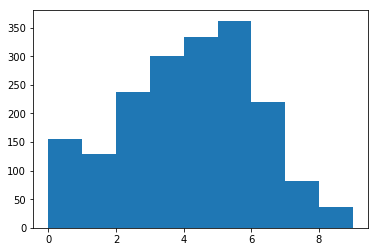

In [29]:
plt.hist(filteredTrial.Score, bins=list(range(10)))

subject comparison between trials

In [30]:
pilot1 = filteredTrial[(filteredTrial.payment == 1) & (filteredTrial.total_unique_trials == 80)].sort_values(by=["SubjectID", 'ImgID'])

In [31]:
pilot1 = pilot1[pilot1.imgName != 'empty-image-1.jpg']

In [38]:
num_of_participants = len(pilot1)//160
matrix = np.array(pilot1.Score).reshape((num_of_participants, 160))
subjects = list(sorted(set(pilot1.SubjectID), key=list(pilot1.SubjectID).index))

1


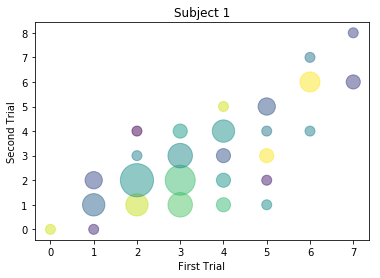

2


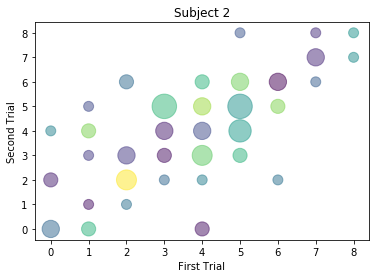

4


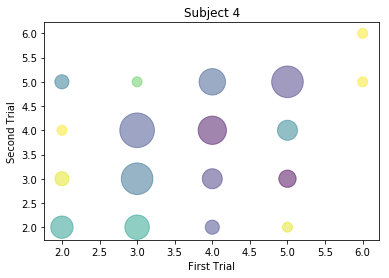

5


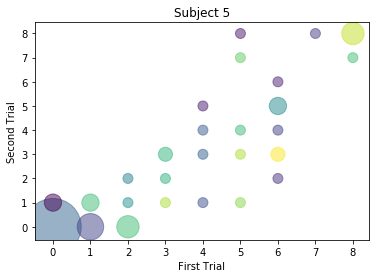

6


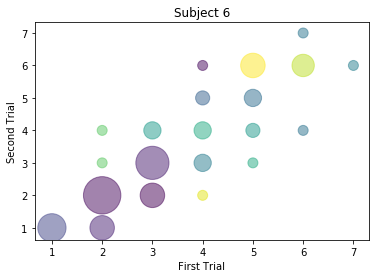

8


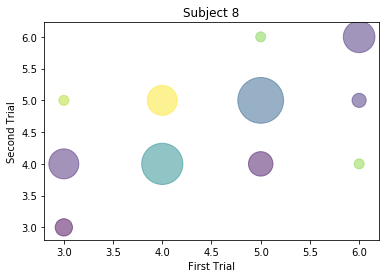

10


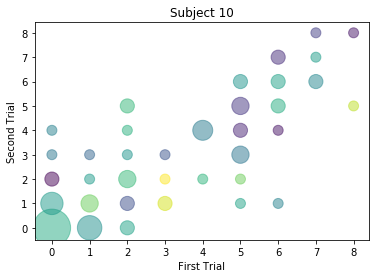

In [39]:
for sub, subid in zip(matrix, subjects):
    x_coor = sub[::2]
    y_coor = sub[1::2]
    # find  each unique coordinate

    # Find the unique sets
    unique_coor = sorted(set(zip(x_coor, y_coor)))
    total_coor = list(zip(x_coor, y_coor))

    size = []
    for coor in unique_coor:
        size.append(total_coor.count(coor))

    x_unique_coor, y_unique_coor = zip(*unique_coor)

    colors = np.random.rand(len(x_unique_coor))
    plt.title('Subject ' + str(subid))
    plt.xlabel('First Trial')
    plt.ylabel('Second Trial')
    #standardize the scale
    plt.scatter(x_unique_coor, y_unique_coor, s=np.array(size) * 100 , alpha=0.5, c=colors)
    plt.show()

In [40]:
for subid, sub in zip(subjects, matrix):
    firstTrial = sub[::2]
    secondTrial = sub[1::2]
    print('Subject ' + str(subid)+ ':', scipy.stats.spearmanr(firstTrial, secondTrial))

Subject 1: SpearmanrResult(correlation=0.6810147852734896, pvalue=3.627568597508833e-12)
Subject 2: SpearmanrResult(correlation=0.6335767576504463, pvalue=2.836116450917553e-10)
Subject 4: SpearmanrResult(correlation=0.48369178125004747, pvalue=5.489216758952672e-06)
Subject 5: SpearmanrResult(correlation=0.8541969882896993, pvalue=7.34388381541905e-24)
Subject 6: SpearmanrResult(correlation=0.8910336663983246, pvalue=1.7737036228401253e-28)
Subject 8: SpearmanrResult(correlation=0.7124357846733574, pvalue=1.253866804254289e-13)
Subject 10: SpearmanrResult(correlation=0.7844774046183944, pvalue=7.442870035683801e-18)


In [42]:
pilot2 = filteredTrial[(filteredTrial.payment == 2) & (filteredTrial.total_unique_trials == 40)].sort_values(by=["SubjectID", 'ImgID'])

In [43]:
pilot2 = pilot2[pilot2.imgName != 'empty-image-1.jpg']

In [44]:
num_of_participants = len(pilot2)//80
matrix = np.array(pilot2.Score).reshape((num_of_participants, 80))
subjects = list(sorted(set(pilot2.SubjectID), key=list(pilot2.SubjectID).index))

11


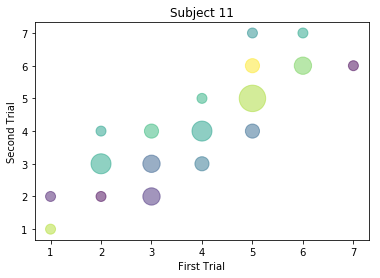

12


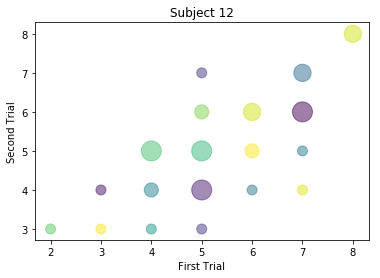

13


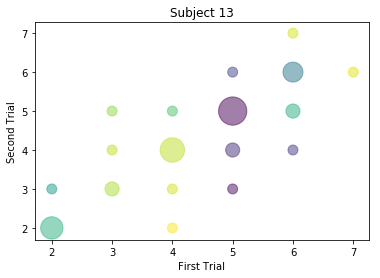

15


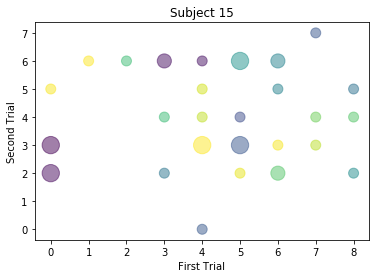

16


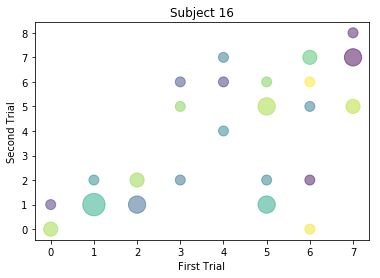

17


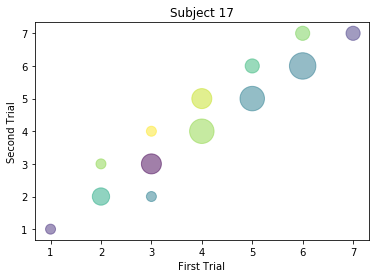

18


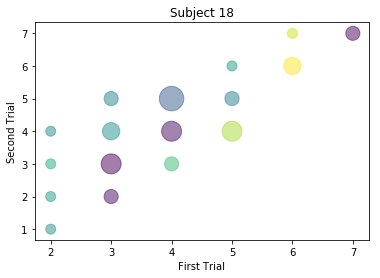

19


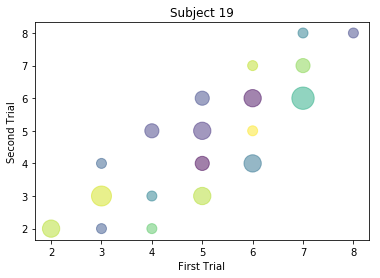

20


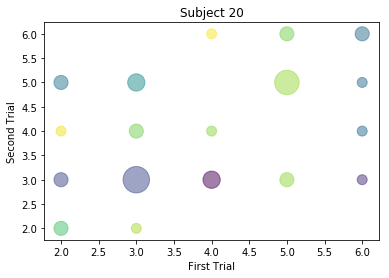

In [45]:
for sub, subid in zip(matrix, subjects):
    print(subid)
    x_coor = sub[::2]
    y_coor = sub[1::2]
    # find  each unique coordinate

    # Find the unique sets
    unique_coor = sorted(set(zip(x_coor, y_coor)))
    total_coor = list(zip(x_coor, y_coor))

    size = []
    for coor in unique_coor:
        size.append(total_coor.count(coor))

    x_unique_coor, y_unique_coor = zip(*unique_coor)

    colors = np.random.rand(len(x_unique_coor))
    plt.title('Subject ' + str(subid))
    plt.xlabel('First Trial')
    plt.ylabel('Second Trial')
    plt.scatter(x_unique_coor, y_unique_coor, s=np.array(size) * 100 , alpha=0.5, c=colors)
    plt.show()

In [46]:
for subid, sub in zip(subjects, matrix):
    firstTrial = sub[::2]
    secondTrial = sub[1::2]
    print('Subject ' + str(subid)+ ':', scipy.stats.spearmanr(firstTrial, secondTrial))

Subject 11: SpearmanrResult(correlation=0.872394976492303, pvalue=2.2499363904410103e-13)
Subject 12: SpearmanrResult(correlation=0.7033050852364949, pvalue=4.168745774905847e-07)
Subject 13: SpearmanrResult(correlation=0.8116479313218077, pvalue=2.099916929373359e-10)
Subject 15: SpearmanrResult(correlation=0.1298948728730852, pvalue=0.42436593821002544)
Subject 16: SpearmanrResult(correlation=0.6782126139133691, pvalue=1.5197303737464882e-06)
Subject 17: SpearmanrResult(correlation=0.9544936114116279, pvalue=1.4500746106651517e-21)
Subject 18: SpearmanrResult(correlation=0.7309549192881237, pvalue=8.518972218485144e-08)
Subject 19: SpearmanrResult(correlation=0.834176422511979, pvalue=2.3012555840790414e-11)
Subject 20: SpearmanrResult(correlation=0.4596220603599156, pvalue=0.002848241083427741)


In [ ]:
pilot3 = filteredTrial[(filteredTrial.payment == 2) & (filteredTrial.total_unique_trials == 80)].sort_values(by=["SubjectID", 'ImgID'])

Mode Frequency of each subject:
Empty Face: those who choose 0, will they have a smaller avg than the people who chose 9. 
* correlate
Intraclass Correlations
personality-project.org/r/html/ICC.html